In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [4]:
# Loading the data
df = pd.read_csv('/Users/ekanshtrivedi/Fetch-MLE/data_daily.csv')

Monthly:

In [41]:
df.head() #We can see that the start date is 2021-01-01 and the end date is  2021-12-31

,Receipt_Count
# Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [6]:
df['# Date'] = pd.to_datetime(df['# Date'])
df.set_index('# Date', inplace=True)
monthly_data = df.resample('M').sum()

In [7]:
monthly_data

,Receipt_Count
# Date,
2021-01-31,236736687
2021-02-28,220033460
2021-03-31,248608625
2021-04-30,250644830
2021-05-31,263151748
2021-06-30,260656840
2021-07-31,274776003
2021-08-31,283943231
2021-09-30,281146154


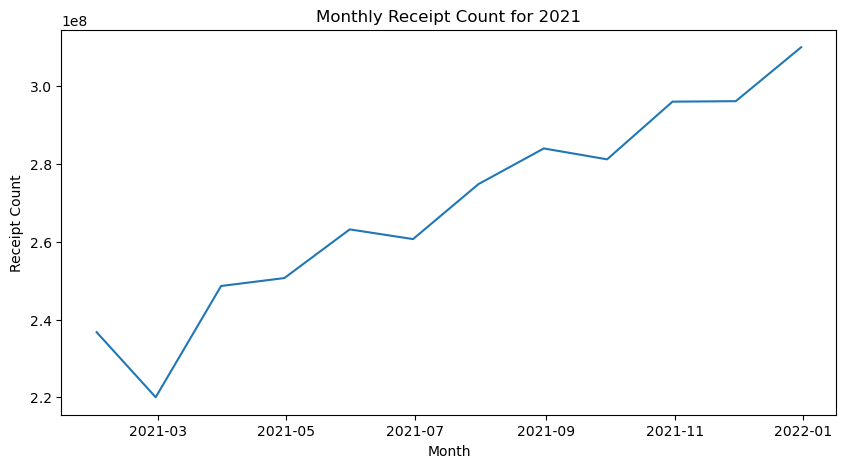

In [8]:
# Plotting the Data to check the Reciept count for 2021
plt.figure(figsize=(10, 5))
plt.plot(monthly_data.index, monthly_data['Receipt_Count'])
plt.title('Monthly Receipt Count for 2021')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.show()

In [9]:
#Feature extarction for the monthly component
monthly_data['month'] = monthly_data.index.month
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data['lag_1'] = monthly_data['Receipt_Count'].shift(1)
monthly_data['rolling_mean_3'] = monthly_data['Receipt_Count'].rolling(window=3).mean()
monthly_data['ewm_3'] = monthly_data['Receipt_Count'].ewm(span=3).mean() 

In [22]:
monthly_data.head()

,Receipt_Count,month,quarter,lag_1,rolling_mean_3,ewm_3
# Date,,,,,,
2021-03-31,248608625,3,1,220033460.0,2.351263e+08,2.387483e+08
2021-04-30,250644830,4,2,248608625.0,2.397623e+08,2.450931e+08
2021-05-31,263151748,5,2,250644830.0,2.541351e+08,2.544137e+08
2021-06-30,260656840,6,2,263151748.0,2.581511e+08,2.575848e+08
2021-07-31,274776003,7,3,260656840.0,2.661949e+08,2.662481e+08


In [11]:
monthly_data.dropna(inplace=True)

In [12]:
train_mon = monthly_data[monthly_data.index <= '2021-09-30']
test_mon = monthly_data[monthly_data.index > '2021-09-30']

In [13]:
X_train = train_mon[['month', 'quarter', 'lag_1', 'rolling_mean_3', 'ewm_3']]
y_train = train_mon['Receipt_Count']
X_test = test_mon[['month', 'quarter', 'lag_1', 'rolling_mean_3', 'ewm_3']]
y_test = test_mon['Receipt_Count']

In [14]:
#Creating a baseline model with Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
lag_1_value = monthly_data['Receipt_Count'].iloc[-1]
ewm_value = monthly_data['Receipt_Count'].ewm(span=12).mean().iloc[-1]
rolling_window = monthly_data['Receipt_Count'].iloc[-3:].tolist()

In [ ]:
#Checking how the model works for predicting reciept counts for 2022.
months_2022 = pd.date_range(start='2022-01-01', end='2022-12-31', freq='MS')
features_2022 = {
    'month': months_2022.month,
    'quarter': months_2022.quarter,  
    'lag_1': [lag_1_value],  
    'rolling_mean_3': [rolling_window],
    'ewm_3': [ewm_value],  
}

X_2022 = pd.DataFrame(features_2022)

In [18]:
predictions = []
for month in range(1, 13):  # Predicting for each month in 2022
    # Calculate the current rolling_mean_3
    rolling_mean_3 = np.mean(rolling_window)

    # Create the feature set for the current prediction
    features = {
    'month': month,
    'quarter': (month - 1) // 3 + 1,  # Placeholder, you might want to adjust this
    'lag_1': lag_1_value,  # Placeholder average value
    'rolling_mean_3': rolling_mean_3,
    'ewm_3': ewm_value,  # Placeholder, you might want to adjust this
}
    X_current = pd.DataFrame([features])
    
    # Making the prediction
    current_pred = model.predict(X_current)[0]
    predictions.append(current_pred)
    
    # Update lag_1, ewm, and rolling_mean_3 for the next prediction
    last_known_value = current_pred
    ewm_value = ewm_value * 0.88 + current_pred * 0.12
    rolling_window.append(current_pred)
    if len(rolling_window) > 3:
        rolling_window.pop(0)  # Keep the window size to 3

# Convert predictions to a DataFrame for plotting or further analysis
predictions_df = pd.DataFrame(predictions, columns=['Predicted'], index=pd.date_range('2022-01-01', periods=12, freq='M'))

In [19]:
predictions_df

,Predicted
2022-01-31,3.394442e+08
2022-02-28,3.462812e+08
2022-03-31,3.530997e+08
2022-04-30,3.618678e+08
2022-05-31,3.697955e+08
2022-06-30,3.779935e+08
2022-07-31,3.882511e+08
2022-08-31,3.975513e+08
2022-09-30,4.073042e+08
2022-10-31,4.193264e+08


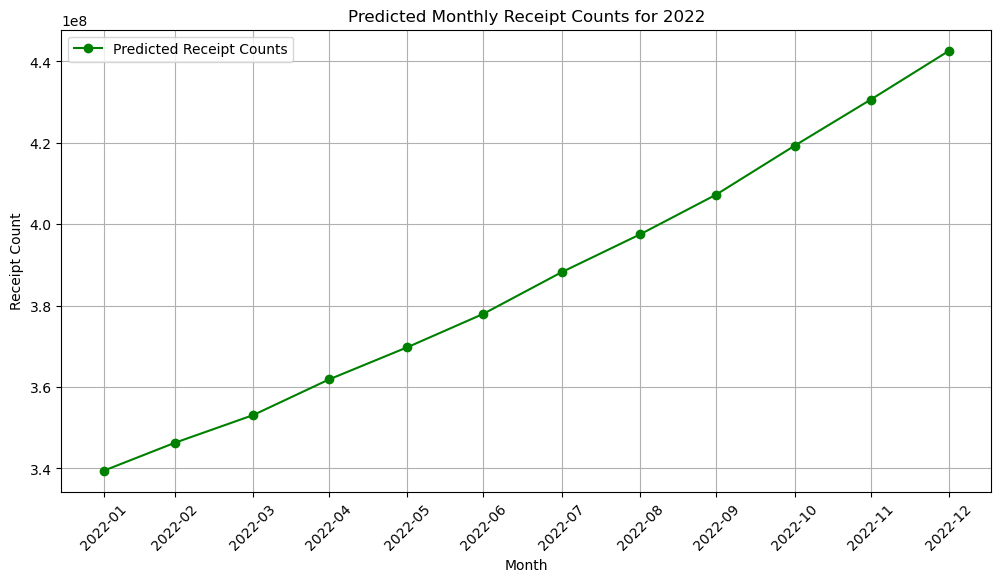

In [20]:
# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted Receipt Counts', color='green', marker='o')
plt.title('Predicted Monthly Receipt Counts for 2022')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.xticks(predictions_df.index, labels=[d.strftime('%Y-%m') for d in predictions_df.index], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [99]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
rmse = sqrt(mse)
print(f'Root Mean square error: {rmse}')

Mean Squared Error: 502862415286.2334
Root Mean square error: 709127.9258964728


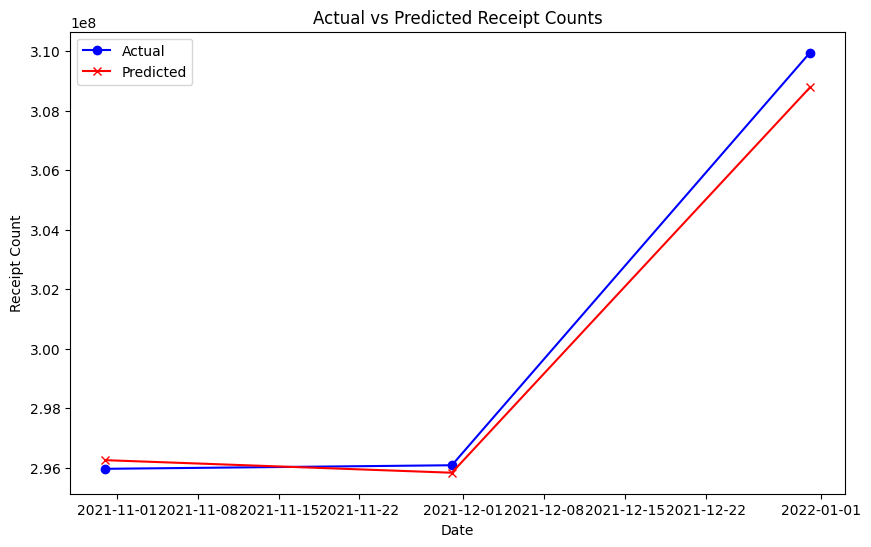

In [16]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, predictions, label='Predicted', color='red', marker='x')
plt.title('Actual vs Predicted Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()

Daily:

In [2]:
df2 = pd.read_csv('/Users/ekanshtrivedi/Fetch-MLE/data_daily.csv')

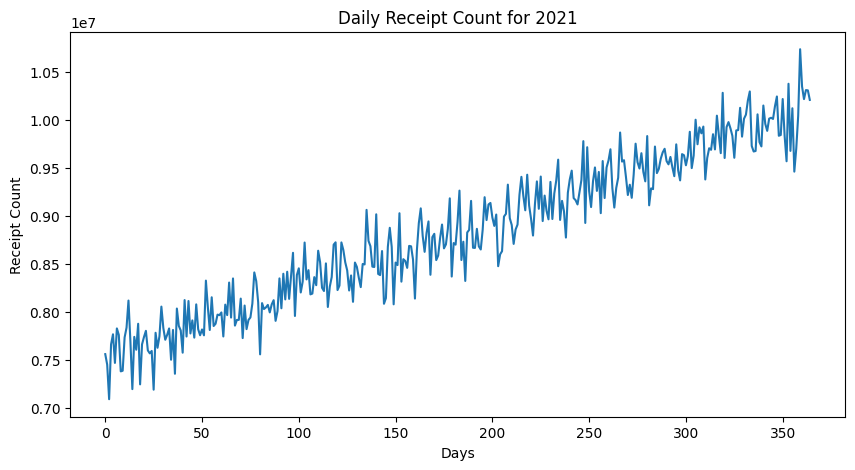

In [3]:
# Plotting the Data
plt.figure(figsize=(10, 5))
plt.plot(df2.index, df2['Receipt_Count'])
plt.title('Daily Receipt Count for 2021')
plt.xlabel('Days')
plt.ylabel('Receipt Count')
plt.show()

In [4]:
# Feature Engineering for the daily data
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
start = df2['# Date'].min()
end = df2['# Date'].max()
holidays = cal.holidays(start=start, end=end)

df2['# Date'] = pd.to_datetime(df2['# Date'])
df2['month'] = df2['# Date'].dt.month
df2['day'] = df2['# Date'].dt.day
df2['day_of_week'] = df2['# Date'].dt.dayofweek  # Monday=0, Sunday=6
df2['quarter'] = df2['# Date'].dt.quarter
df2['is_weekend'] = df2['# Date'].dt.dayofweek >= 5  # 5 and 6 correspond to Saturday and Sunday
df2['is_holiday'] = df2['# Date'].isin(holidays).astype(int)

In [7]:
df2.head()

,# Date,Receipt_Count,month,day,day_of_week,quarter,is_weekend,is_holiday
0,2021-01-01,7564766,1,1,4,1,False,1
1,2021-01-02,7455524,1,2,5,1,True,0
2,2021-01-03,7095414,1,3,6,1,True,0
3,2021-01-04,7666163,1,4,0,1,False,0
4,2021-01-05,7771289,1,5,1,1,False,0


In [5]:
split_date = pd.Timestamp('2021-09-01')  # Replace 'YYYY-MM-DD' with your split date

In [6]:
# Split the data into training and testing sets
train = df2.loc[df2['# Date'] < split_date]
test = df2.loc[df2['# Date'] >= split_date]

# For instance:
X_train = train[['month', 'day', 'day_of_week', 'quarter', 'is_weekend', 'is_holiday']]
y_train = train['Receipt_Count']
X_test = test[['month', 'day', 'day_of_week', 'quarter', 'is_weekend', 'is_holiday']]
y_test = test['Receipt_Count']

In [10]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
months_2022 = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')


In [12]:
months_2022

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [13]:
#months_2022 = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
start = '2022-01-01'
end = '2022-12-31'
holidays = cal.holidays(start=start, end=end)
features_2022 = {
    'month': months_2022.month,
    'day': months_2022.day,  # Placeholder, you might want to adjust this
    'day_of_week': months_2022.dayofweek,  # Placeholder average value
    'quarter': months_2022.quarter,
    'is_weekend': months_2022.dayofweek >= 5,  # Placeholder, you might want to adjust this
    'is_holiday': months_2022.isin(holidays).astype(int),  # Placeholder, adjust if you have holiday info
}

X_2022 = pd.DataFrame(features_2022)

In [14]:
predictions_2022 = model.predict(X_2022)

In [15]:
predictions_2022 = pd.DataFrame({
    'Date': months_2022,
    'Predictions': predictions_2022.flatten()  # Flatten in case predictions_2022 is 2D
})

# Set 'Date' as a datetime index
predictions_2022['Date'] = pd.to_datetime(predictions_2022['Date'])
predictions_2022.set_index('Date', inplace=True)

# Aggregate to monthly predictions
monthly_predictions_2022 = predictions_2022.resample('M').sum()

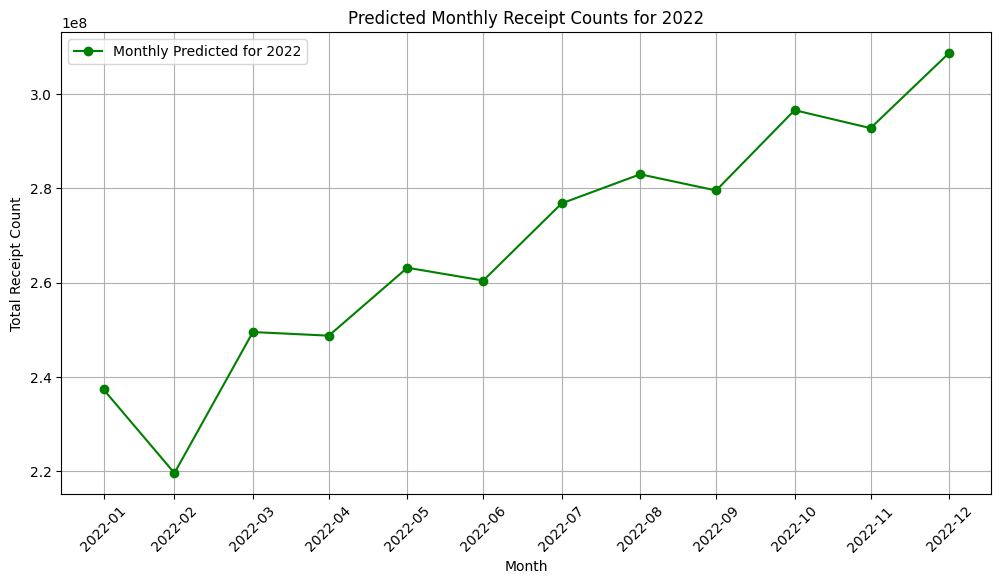

In [16]:
# Plotting monthly predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_2022.index, monthly_predictions_2022['Predictions'], label='Monthly Predicted for 2022', color='green', marker='o')
plt.title('Predicted Monthly Receipt Counts for 2022')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')
plt.xticks(monthly_predictions_2022.index, labels=[d.strftime('%Y-%m') for d in monthly_predictions_2022.index], rotation=45)
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 50076808095.53212


In [19]:
from math import sqrt

rmse = sqrt(mse)
print(f'Root Mean square error: {rmse}')

Root Mean square error: 223778.47996519264


In [20]:
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 1.844440850015251%


In [21]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

R-squared: 0.555555730717012


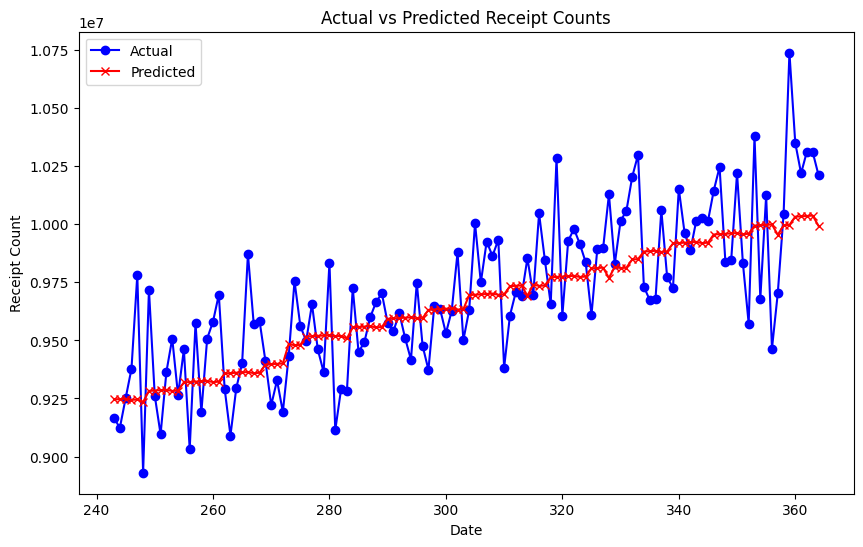

In [22]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, predictions, label='Predicted', color='red', marker='x')
plt.title('Actual vs Predicted Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()

LSTM model:

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
scaled_train = scaler.fit_transform(train['Receipt_Count'].values.reshape(-1,1))

# Transform the test data
scaled_test = scaler.transform(test['Receipt_Count'].values.reshape(-1,1))

In [9]:
from keras.models import load_model

# Load the Keras model from disk
lstm_model = load_model('/Users/ekanshtrivedi/Fetch-MLE/trained_models/LSTM.h5')
rnn_model = load_model('/Users/ekanshtrivedi/Fetch-MLE/trained_models/RNN.h5')

In [10]:
import pickle

# Load the model from disk
with open('/Users/ekanshtrivedi/Fetch-MLE/trained_models/prophet.pkl', 'rb') as file:
    prophet_model = pickle.load(file)

Importing plotly failed. Interactive plots will not work.


In [11]:
X_lstm = []
y_lstm = []
sequence_length = 60 

for i in range(sequence_length, len(scaled_train)):
    X_lstm.append(scaled_train[i-sequence_length:i, 0])
    y_lstm.append(scaled_train[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


In [25]:
#Creating a baseline LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_lstm, y_lstm, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 2s 21ms/step - loss: 0.2265
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0328
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0158
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0198
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0110
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0124
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0093
Epoch 8/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0101
Epoch 9/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0093
Epoch 10/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0092
Epoch 11/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0090
Epoch 12/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0089
Epoch 13/100
6/6 [==============================]

In [61]:
def build_model(n_layers, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True if n_layers > 1 else False, input_shape=(X_lstm.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_layers):
        model.add(LSTM(units=units, return_sequences=(i < n_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [62]:
from keras.optimizers import Adam, RMSprop, SGD

n_layers_options = [1, 2, 3]  # Number of LSTM layers
units_options = [50, 100]  # Number of units in each layer
dropout_rate_options = [0.2, 0.5]  # Dropout rate
learning_rate_options = [0.001, 0.01]  # Learning rate
batch_size_options = [32, 64]  # Batch size
epochs = 50  # Number of epochs to train

In [63]:
#Finding out the best model for LSTM
from sklearn.metrics import mean_squared_error

best_score = float('inf')
best_params = None

for n_layers in n_layers_options:
    for units in units_options:
        for dropout_rate in dropout_rate_options:
            for learning_rate in learning_rate_options:
                for batch_size in batch_size_options:
                    # Build the model
                    model = build_model(n_layers, units, dropout_rate, learning_rate)
                    
                    # Train the model
                    model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, verbose=0)

                    # Evaluate the model (use a validation set or cross-validation)
                    # For simplicity, using the training set here; replace with your validation set
                    predictions = model.predict(X_lstm)
                    score = mean_squared_error(y_lstm, predictions)

                    # Update best score
                    if score < best_score:
                        best_score = score
                        best_params = (n_layers, units, dropout_rate, learning_rate, batch_size)

print(f'Best Score (MSE): {best_score}')
print(f'Best Hyperparameters: {best_params}')

6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 1s 3ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 8ms/step


6/6 [==============================] - 0s 11ms/step


6/6 [==============================] - 0s 29ms/step


6/6 [==============================] - 1s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 1s 13ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 1s 14ms/step


6/6 [==============================] - 1s 18ms/step


6/6 [==============================] - 1s 27ms/step


6/6 [==============================] - 1s 28ms/step


6/6 [==============================] - 1s 17ms/step


6/6 [==============================] - 1s 29ms/step


6/6 [==============================] - 1s 21ms/step


6/6 [==============================] - 1s 30ms/step


6/6 [==============================] - 1s 14ms/step


6/6 [==============================] - 1s 9ms/step


6/6 [==============================] - 1s 12ms/step


6/6 [==============================] - 1s 8ms/step


6/6 [==============================] - 1s 9ms/step


6/6 [==============================] - 1s 10ms/step


6/6 [==============================] - 1s 11ms/step


6/6 [==============================] - 1s 15ms/step


6/6 [==============================] - 1s 13ms/step


6/6 [==============================] - 1s 32ms/step


6/6 [==============================] - 1s 30ms/step


6/6 [==============================] - 1s 21ms/step


6/6 [==============================] - 1s 24ms/step


6/6 [==============================] - 1s 24ms/step


6/6 [==============================] - 2s 31ms/step


6/6 [==============================] - 1s 27ms/step


6/6 [==============================] - 1s 24ms/step
Best Score (MSE): 0.008188680789181306
Best Hyperparameters: (3, 100, 0.2, 0.001, 64)


In [65]:
lstm_model = build_model(3,100,0.2, 0.001)

In [66]:
lstm_model.fit(X_lstm, y_lstm, epochs=100, batch_size=64)

Epoch 1/100
3/3 [==============================] - 4s 114ms/step - loss: 0.2254
Epoch 2/100
3/3 [==============================] - 0s 108ms/step - loss: 0.0595
Epoch 3/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0259
Epoch 4/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0412
Epoch 5/100
3/3 [==============================] - 0s 111ms/step - loss: 0.0151
Epoch 6/100
3/3 [==============================] - 0s 114ms/step - loss: 0.0223
Epoch 7/100
3/3 [==============================] - 0s 112ms/step - loss: 0.0145
Epoch 8/100
3/3 [==============================] - 0s 113ms/step - loss: 0.0141
Epoch 9/100
3/3 [==============================] - 0s 121ms/step - loss: 0.0167
Epoch 10/100
3/3 [==============================] - 0s 115ms/step - loss: 0.0130
Epoch 11/100
3/3 [==============================] - 0s 111ms/step - loss: 0.0146
Epoch 12/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0132
Epoch 13/100
3/3 [===================

In [67]:
# Get the last sequence from the existing data
last_sequence = scaled_train[-sequence_length:]

num_future_steps = 365  # For example, predicting for the next 365 days

future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(num_future_steps):
    # Reshape the sequence to match the model's input format
    current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
    
    # Predict the next step
    next_prediction = lstm_model.predict(current_sequence_reshaped)[0][0]
    
    # Append the prediction to the list
    future_predictions.append(next_prediction)
    
    # Update the sequence with the new prediction
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = next_prediction

1/1 [==============================] - 0s 25ms/step


In [26]:
# Combine the end of the training set with the test set
combined = np.concatenate((scaled_train[-sequence_length:], scaled_test), axis=0)

# Create sequences for the test set
X_test_lstm = []
for i in range(sequence_length, len(combined)):
    X_test_lstm.append(combined[i-sequence_length:i, 0])

X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [27]:
# Make predictions
predictions_scaled = model_lstm.predict(X_test_lstm)

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions_scaled).flatten()
actual = test['Receipt_Count'].values[-len(predictions):]

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

4/4 [==============================] - 0s 6ms/step
Mean Squared Error: 68711725978.94262


In [28]:
rmse = sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 262129.2161872511


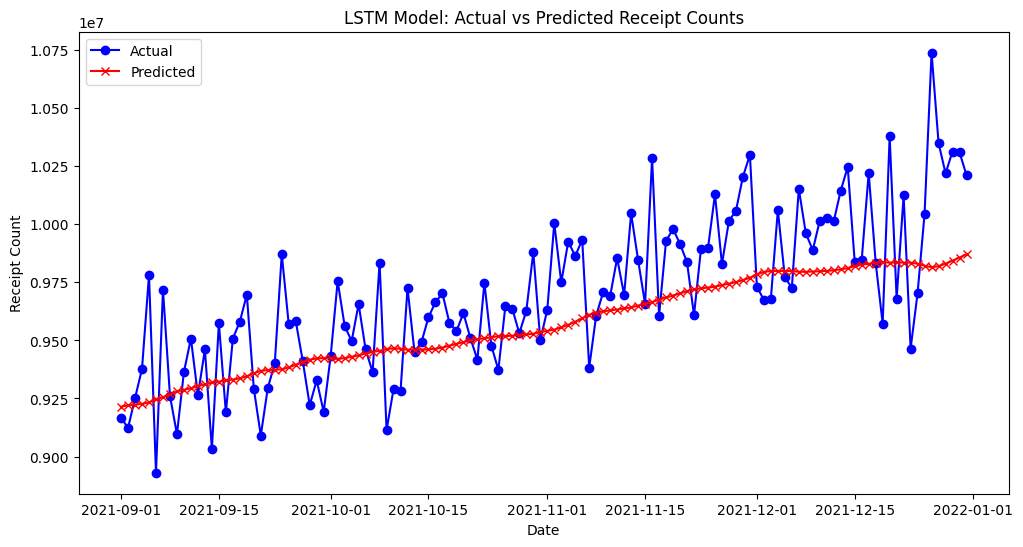

In [29]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['# Date'].values[-len(predictions):], actual, label='Actual', color='blue', marker='o')
plt.plot(test['# Date'].values[-len(predictions):], predictions, label='Predicted', color='red', marker='x')
plt.title('LSTM Model: Actual vs Predicted Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()

In [14]:
# Predict for each day of 2022
predictions_2022 = []
current_sequence = last_sequence.copy()

for _ in range(365):  # Number of days in 2022
    # Reshape the sequence for the model
    current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
    # Predict the next step
    next_prediction = lstm_model.predict(current_sequence_reshaped)[0][0]
    # Append the prediction
    predictions_2022.append(next_prediction)
    # Update the sequence
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = next_prediction


1/1 [==============================] - 0s 15ms/step


In [13]:
last_sequence = scaled_train[-sequence_length:]

In [15]:
predictions_2022_original_scale = scaler.inverse_transform(np.array(predictions_2022).reshape(-1, 1)).flatten()


In [16]:
# Create a DataFrame for the predictions
dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')
monthly_predictions_df = pd.DataFrame({'Date': dates_2022, 'Prediction': predictions_2022_original_scale})
monthly_predictions_df.set_index('Date', inplace=True)
# Resample and sum to get monthly predictions
monthly_predictions = monthly_predictions_df.resample('M').sum()


In [17]:
monthly_predictions

,Prediction
Date,
2022-01-31,290829056.0
2022-02-28,268564704.0
2022-03-31,302648032.0
2022-04-30,296951936.0
2022-05-31,309863232.0
2022-06-30,301875104.0
2022-07-31,313314720.0
2022-08-31,314223840.0
2022-09-30,304640960.0


In [19]:
monthly_predictions.to_csv('/Users/ekanshtrivedi/Fetch-MLE/LSTM_predictions.csv')

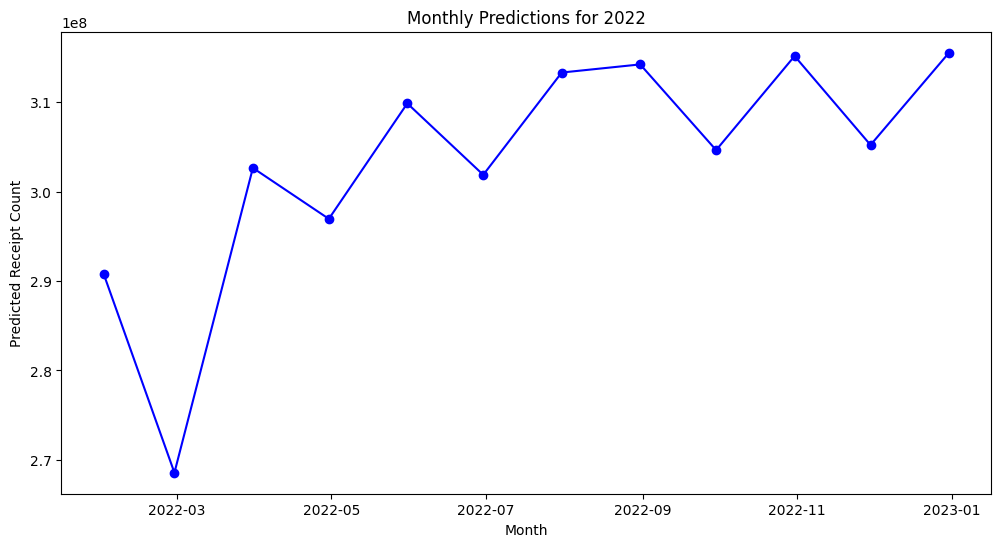

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions.index, monthly_predictions['Prediction'], label='Predicted Receipt Count', color='blue', marker='o')
plt.title('Monthly Predictions for 2022')
plt.xlabel('Month')
plt.ylabel('Predicted Receipt Count')
plt.show()

RNN model:

In [56]:
#Creating baseline RNN model
from keras.layers import SimpleRNN

# RNN Network (using the same preprocessed data as LSTM)
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_lstm, y_lstm, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 1s 9ms/step - loss: 0.0487
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0096
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 12/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 13/100
6/6 [==============================] - 0s 9

In [57]:
# Make predictions with RNN
predictions_scaled_rnn = model_rnn.predict(X_test_lstm)

# Inverse transform predictions
predictions_rnn = scaler.inverse_transform(predictions_scaled_rnn).flatten()

4/4 [==============================] - 0s 3ms/step


In [58]:
# Calculate MSE
mse_rnn = mean_squared_error(actual, predictions_rnn)
print(f"Mean Squared Error (RNN): {mse_rnn}")

# Calculate RMSE
rmse_rnn = np.sqrt(mse_rnn)
print(f"Root Mean Squared Error (RNN): {rmse_rnn}")


Mean Squared Error (RNN): 192327011140.83606
Root Mean Squared Error (RNN): 438551.0359591413


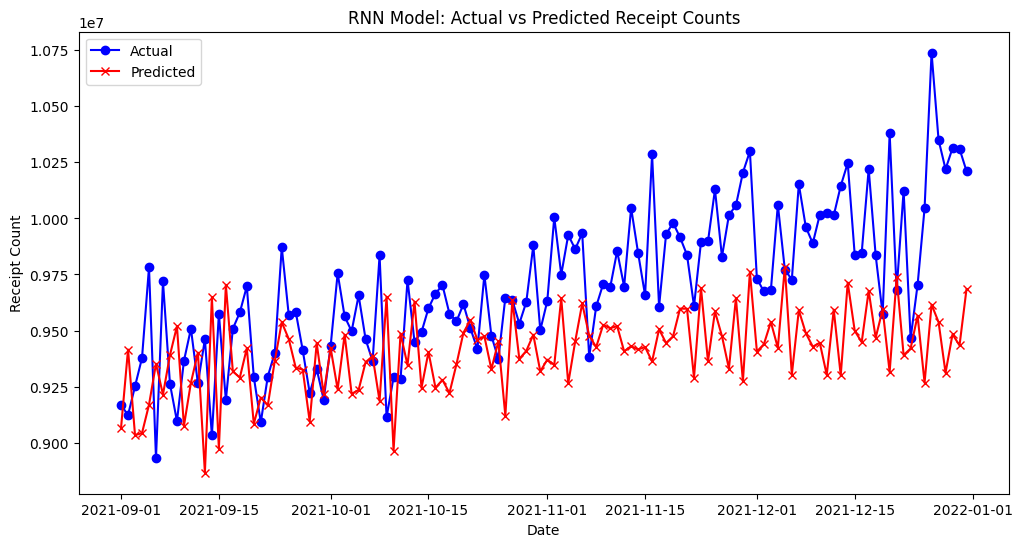

In [59]:
# Plotting actual vs predicted values for RNN
plt.figure(figsize=(12, 6))
plt.plot(test['# Date'].values[-len(predictions_rnn):], actual, label='Actual', color='blue', marker='o')
plt.plot(test['# Date'].values[-len(predictions_rnn):], predictions_rnn, label='Predicted', color='red', marker='x')
plt.title('RNN Model: Actual vs Predicted Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()


In [73]:
def build_rnn_model(n_layers, units, dropout_rate, learning_rate, input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True if n_layers > 1 else False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_layers):
        model.add(SimpleRNN(units=units, return_sequences=(i < n_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [76]:
#Finding out the best model for RNN
best_score = float('inf')
best_params = None

for n_layers in n_layers_options:
    for units in units_options:
        for dropout_rate in dropout_rate_options:
            for learning_rate in learning_rate_options:
                for batch_size in batch_size_options:
                    # Build the model
                    model_rnn = build_rnn_model(n_layers, units, dropout_rate, learning_rate, X_lstm.shape[1:])
                    
                    # Train the model
                    model_rnn.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, verbose=0)

                    # Evaluate the model (use a validation set or cross-validation)
                    predictions = model_rnn.predict(X_lstm)
                    score = mean_squared_error(y_lstm, predictions)

                    # Update best score
                    if score < best_score:
                        best_score = score
                        best_params = (n_layers, units, dropout_rate, learning_rate, batch_size)

print(f'Best Score (MSE): {best_score}')
print(f'Best Hyperparameters: {best_params}')

6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 1ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 2ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 5ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 5ms/step


6/6 [==============================] - 0s 12ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 5ms/step


6/6 [==============================] - 0s 6ms/step


6/6 [==============================] - 0s 7ms/step


6/6 [==============================] - 0s 6ms/step
Best Score (MSE): 0.0062253305171381945
Best Hyperparameters: (1, 100, 0.2, 0.001, 32)


In [77]:
rnn_model = build_rnn_model(1, 100, 0.2, 0.001, (X_lstm.shape[1], 1))

In [78]:
rnn_model.fit(X_lstm, y_lstm, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 1s 6ms/step - loss: 0.3318
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0963
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0720
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0607
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0386
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0268
Epoch 9/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 12/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0207
Epoch 13/100
6/6 [==============================] - 0s 9ms/st

In [20]:
# Predict for each day of 2022
predictions_2022_rnn = []
current_sequence = last_sequence.copy()

for _ in range(365):  # Number of days in 2022
    # Reshape the sequence for the model
    current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
    # Predict the next step
    next_prediction = rnn_model.predict(current_sequence_reshaped)[0][0]
    # Append the prediction
    predictions_2022_rnn.append(next_prediction)
    # Update the sequence
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = next_prediction

1/1 [==============================] - 0s 11ms/step


In [21]:
last_sequence = scaled_train[-sequence_length:]

In [22]:
predictions_2022_original_scale_rnn = scaler.inverse_transform(np.array(predictions_2022_rnn).reshape(-1, 1)).flatten()


In [23]:
# Create a DataFrame for the predictions
dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')
monthly_predictions_df_rnn = pd.DataFrame({'Date': dates_2022, 'Prediction': predictions_2022_original_scale_rnn})
monthly_predictions_df_rnn.set_index('Date', inplace=True)
# Resample and sum to get monthly predictions
monthly_predictions_rnn = monthly_predictions_df_rnn.resample('M').sum()

In [24]:
monthly_predictions_rnn.to_csv('/Users/ekanshtrivedi/Fetch-MLE/RNN_predictions.csv')

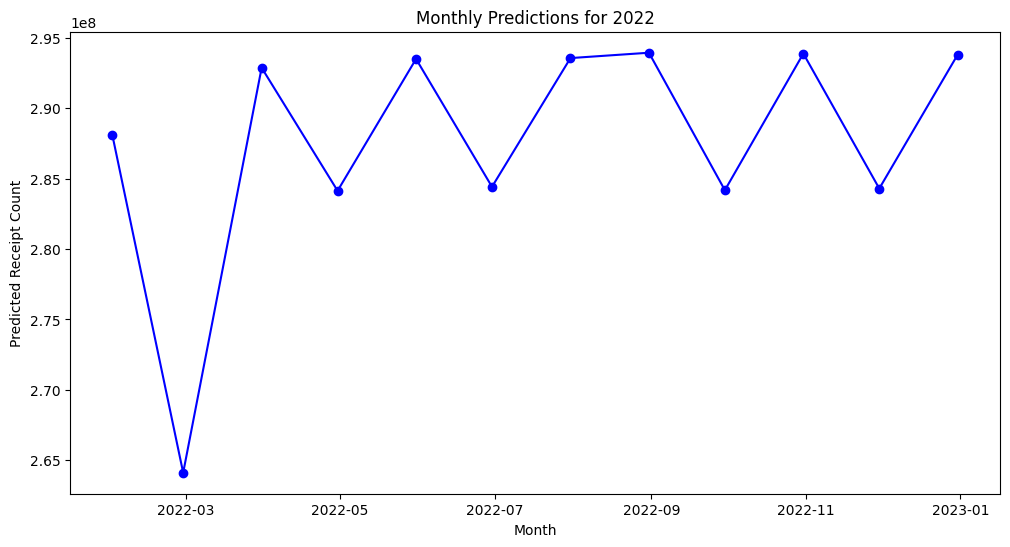

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_rnn.index, monthly_predictions_rnn['Prediction'], label='Predicted Receipt Count', color='blue', marker='o')
plt.title('Monthly Predictions for 2022')
plt.xlabel('Month')
plt.ylabel('Predicted Receipt Count')
plt.show()

Prophet:

In [37]:
from prophet import Prophet

# Preparing data for Prophet
df_prophet = df2.reset_index().rename(columns={'# Date': 'ds', 'Receipt_Count': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future dataframe and predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


10:04:23 - cmdstanpy - INFO - Chain [1] start processing
10:04:23 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
725 2022-12-27  1.273090e+07  1.245138e+07  1.298829e+07
726 2022-12-28  1.277655e+07  1.248964e+07  1.305414e+07
727 2022-12-29  1.277792e+07  1.248709e+07  1.307165e+07
728 2022-12-30  1.279031e+07  1.249846e+07  1.308031e+07
729 2022-12-31  1.282940e+07  1.254868e+07  1.310763e+07


In [38]:
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Set 'ds' as the index
forecast.set_index('ds', inplace=True)

# Resample and sum to get monthly predictions
monthly_forecast = forecast.resample('M').sum()

# Now, monthly_forecast contains monthly summed predictions
print(monthly_forecast[['yhat', 'yhat_lower', 'yhat_upper']])

                    yhat    yhat_lower    yhat_upper
ds                                                  
2021-01-31  2.369392e+08  2.283349e+08  2.455230e+08
2021-02-28  2.198544e+08  2.121584e+08  2.275190e+08
2021-03-31  2.498852e+08  2.413899e+08  2.583987e+08
2021-04-30  2.482993e+08  2.400974e+08  2.565762e+08
2021-05-31  2.632030e+08  2.546742e+08  2.717539e+08
2021-06-30  2.609969e+08  2.527569e+08  2.692513e+08
2021-07-31  2.763895e+08  2.678141e+08  2.850697e+08
2021-08-31  2.832539e+08  2.746962e+08  2.918438e+08
2021-09-30  2.808089e+08  2.724525e+08  2.891714e+08
2021-10-31  2.970748e+08  2.884669e+08  3.057020e+08
2021-11-30  2.941317e+08  2.858227e+08  3.025096e+08
2021-12-31  3.108396e+08  3.021427e+08  3.193517e+08
2022-01-31  3.178816e+08  3.093529e+08  3.265189e+08
2022-02-28  2.931048e+08  2.853082e+08  3.008653e+08
2022-03-31  3.311351e+08  3.225845e+08  3.397459e+08
2022-04-30  3.271930e+08  3.188816e+08  3.355336e+08
2022-05-31  3.449231e+08  3.363882e+08  3.5353

In [27]:
# Filter to include only rows for the year 2022
forecast_2022 = monthly_forecast.loc['2022']

In [31]:
forecast_2022

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2022-01-31,3.178442e+08,3.093801e+08,3.264966e+08,3.178355e+08,3.178533e+08,3.742706e+04,3.742706e+04,3.742706e+04,3.742706e+04,3.742706e+04,3.742706e+04,0.0,0.0,0.0,3.178816e+08
2022-02-28,2.931048e+08,2.853783e+08,3.008021e+08,2.930648e+08,2.931485e+08,5.242582e-07,5.242582e-07,5.242582e-07,5.242582e-07,5.242582e-07,5.242582e-07,0.0,0.0,0.0,2.931048e+08
2022-03-31,3.311737e+08,3.225437e+08,3.397238e+08,3.310801e+08,3.312823e+08,-3.852943e+04,-3.852943e+04,-3.852943e+04,-3.852943e+04,-3.852943e+04,-3.852943e+04,0.0,0.0,0.0,3.311351e+08
2022-04-30,3.271590e+08,3.188545e+08,3.355632e+08,3.270056e+08,3.273451e+08,3.400891e+04,3.400891e+04,3.400891e+04,3.400891e+04,3.400891e+04,3.400891e+04,0.0,0.0,0.0,3.271930e+08
2022-05-31,3.449550e+08,3.362513e+08,3.534963e+08,3.447234e+08,3.452399e+08,-3.192953e+04,-3.192953e+04,-3.192953e+04,-3.192953e+04,-3.192953e+04,-3.192953e+04,0.0,0.0,0.0,3.449231e+08
2022-06-30,3.404958e+08,3.321547e+08,3.487573e+08,3.401867e+08,3.408645e+08,-2.079388e+03,-2.079388e+03,-2.079388e+03,-2.079388e+03,-2.079388e+03,-2.079388e+03,0.0,0.0,0.0,3.404937e+08
2022-07-31,3.587363e+08,3.501306e+08,3.673258e+08,3.583065e+08,3.592091e+08,1.544447e+04,1.544447e+04,1.544447e+04,1.544447e+04,1.544447e+04,1.544447e+04,0.0,0.0,0.0,3.587518e+08
2022-08-31,3.657399e+08,3.571491e+08,3.743860e+08,3.651980e+08,3.663119e+08,-1.144590e+04,-1.144590e+04,-1.144590e+04,-1.144590e+04,-1.144590e+04,-1.144590e+04,0.0,0.0,0.0,3.657285e+08
2022-09-30,3.606103e+08,3.523478e+08,3.689546e+08,3.599853e+08,3.612837e+08,-2.896200e+03,-2.896200e+03,-2.896200e+03,-2.896200e+03,-2.896200e+03,-2.896200e+03,0.0,0.0,0.0,3.606074e+08


In [32]:
monthly_predictions_prophet = forecast_2022[['yhat']]
monthly_predictions_prophet

,yhat
ds,
2022-01-31,3.178816e+08
2022-02-28,2.931048e+08
2022-03-31,3.311351e+08
2022-04-30,3.271930e+08
2022-05-31,3.449231e+08
2022-06-30,3.404937e+08
2022-07-31,3.587518e+08
2022-08-31,3.657285e+08
2022-09-30,3.606074e+08


In [39]:
monthly_predictions_prophet = monthly_predictions_prophet.reset_index()

,ds,yhat
0,2022-01-31,3.178816e+08
1,2022-02-28,2.931048e+08
2,2022-03-31,3.311351e+08
3,2022-04-30,3.271930e+08
4,2022-05-31,3.449231e+08
5,2022-06-30,3.404937e+08
6,2022-07-31,3.587518e+08
7,2022-08-31,3.657285e+08
8,2022-09-30,3.606074e+08
9,2022-10-31,3.795587e+08


In [40]:
monthly_predictions_prophet.to_csv('/Users/ekanshtrivedi/Fetch-MLE/Prophet_predictions.csv')

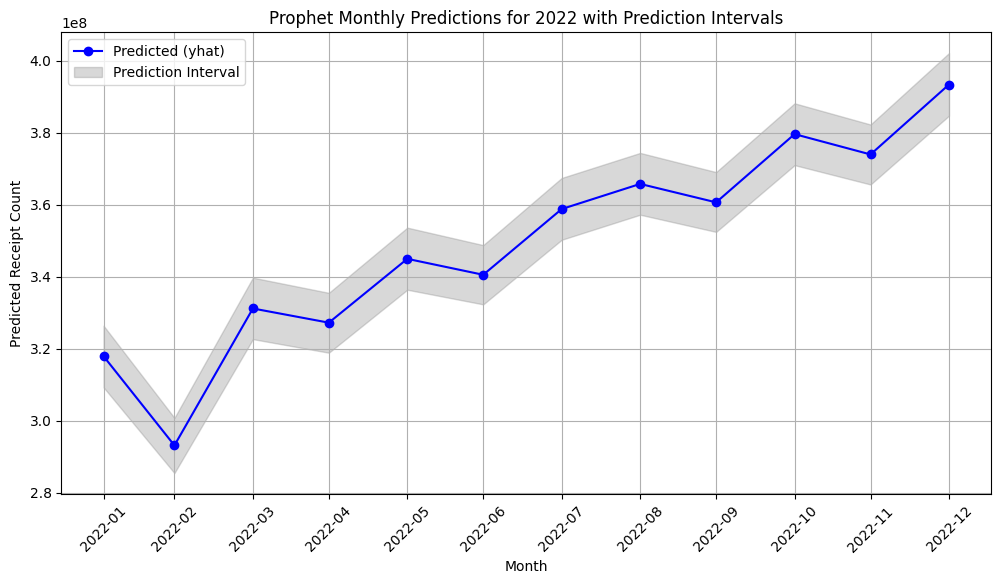

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_2022.index, forecast_2022['yhat'], label='Predicted (yhat)', color='blue', marker='o')

# Plotting the prediction intervals
plt.fill_between(forecast_2022.index, forecast_2022['yhat_lower'], forecast_2022['yhat_upper'], color='gray', alpha=0.3, label='Prediction Interval')

plt.title('Prophet Monthly Predictions for 2022 with Prediction Intervals')
plt.xlabel('Month')
plt.ylabel('Predicted Receipt Count')
plt.xticks(forecast_2022.index, labels=[d.strftime('%Y-%m') for d in forecast_2022.index], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [90]:
rnn_model.save('/Users/ekanshtrivedi/Fetch-MLE/RNN.h5')  # Saves the RNN model
lstm_model.save('/Users/ekanshtrivedi/Fetch-MLE/LSTM.h5')  # Saves the LSTM model

# Saving Prophet with Pickle
import pickle
with open('/Users/ekanshtrivedi/Fetch-MLE/prophet.pkl', 'wb') as f:
    pickle.dump(model, f)


/Users/ekanshtrivedi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
'''
from joblib import dump
dump(lr_model, 'path_to_my_lr_model.joblib')
'''